# Visualizing on Web Image

This notebook is an example of an web image segmentation. Specifically, dog, cat, and grass categories are segmented in this example.

The pre-trained checkpoint for the visualization can be downloaded from https://drive.google.com/file/d/167sIrrSsBTRQlrVHYMKYoWA5A9r04eAD/view?usp=sharing

In [5]:
import torch
import numpy as np
from fairseq import checkpoint_utils, distributed_utils, options, tasks, utils
from fairseq.dataclass.utils import convert_namespace_to_omegaconf
from tasks import *
from criterions import *

from models.segofa import SegOFAModel
from PIL import Image

tasks.register_task('segmentation', SegmentationTask)

# turn on cuda if GPU is available
use_cuda = torch.cuda.is_available()

In [ ]:
# Load pretrained ckpt & config
ckpt = './figure_checkpoint.pt'

overrides={"prompt_prefix": 'what is the segmentation map of the image? object:',
           'batch_size_valid': 1,
           'patch_image_size': 512,
           'orig_patch_image_size': 512,
           'num_seg_tokens': 5,
           'category_list': 'plant, grass, cat, dog, other'
           }
models, cfg, task = checkpoint_utils.load_model_ensemble_and_task(
        utils.split_paths(ckpt),
        arg_overrides=overrides
    )

model = models[0]
if use_cuda:
    model.cuda()
model.eval()

In [7]:
from einops import rearrange
from mmseg.ops import resize
import matplotlib.pyplot as plt
from crf import rgb_dense_crf
import torchvision.transforms.functional as VF

def dataset_cmap(dataset):
    if dataset == 'demo':
        cmap = [(168, 163, 125),
                (115, 246, 88),
                (158, 150, 52),
                (234, 51, 198),
                (60, 60, 60)]

    return np.array(cmap)

def _remove_axes(ax):
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])


def remove_axes(axes):
    if len(axes.shape) == 2:
        for ax1 in axes:
            for ax in ax1:
                _remove_axes(ax)
    else:
        for ax in axes:
            _remove_axes(ax)
            
def encode_text(text):
    line = [task.bpe.encode(' {}'.format(word.strip())) for word in text.strip().split()]
    line = ' '.join(line)
    
    s = task.tgt_dict.encode_line(
        line=line,
        add_if_not_exist=False,
        append_eos=False
    ).long()
    return s

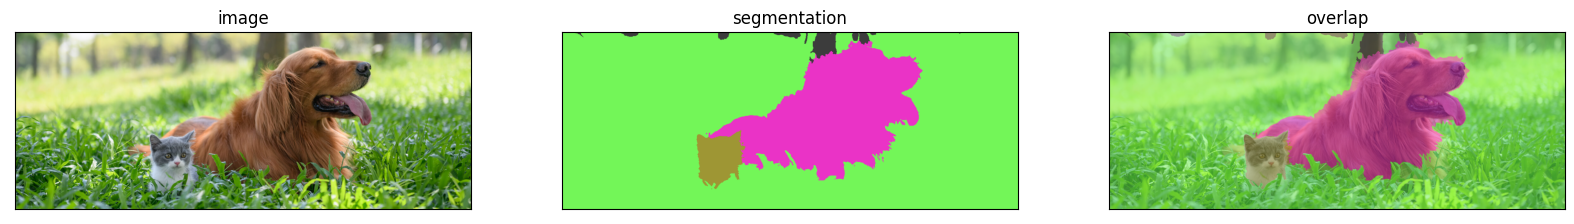

In [8]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
from mmseg.datasets.pipelines import MultiScaleFlipAug
import matplotlib.pyplot as plt

cmap = dataset_cmap('demo')
mean = std = [0.5, 0.5, 0.5]
image_normalize = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=mean, std=std)])

image_transform = MultiScaleFlipAug(img_scale=(512*4, 512),
                                    flip=False,
                                    transforms=[dict(type='Resize', keep_ratio=True),
                                                dict(type='RandomFlip')])

pil_image = Image.open('cat_dog.jpeg')
image_arr = np.asarray(pil_image).copy()
image_arr_bgr = image_arr[:, :, ::-1].copy() # to BGR
ori_shape = image_arr_bgr.shape

results = {}
results['img'] = image_arr_bgr
results['img_shape'] = ori_shape
results['scale_factor'] = 1.0

img_dict = image_transform(results)
img = img_dict.pop('img')[0]
img = img[:, :, ::-1].copy() # to RGB
img = image_normalize(img)

classes = ['plant', 'grass', 'cat', 'dog', 'other', 'unknown']
bos_item = torch.tensor([0])
eos_item = torch.tensor([2])
prompt = encode_text(' what is the segmentation map of the image? object:')
id2text = [encode_text(f" {x}") for x in classes]

src_text = torch.cat([bos_item, prompt, *id2text, eos_item], dim=0)
net_input =  {
    "src_tokens": src_text.unsqueeze(0),
    "src_lengths": torch.tensor([len(src_text)]),
    "patch_images": img.unsqueeze(0),
    "patch_masks": torch.tensor([True]),
    "prev_output_tokens": bos_item.unsqueeze(0)
    }


resnet_topk = 5
resnet_iters = 25
crf_iters = 10
net_input = utils.move_to_cuda(net_input) if use_cuda else net_input
with torch.inference_mode():
    batch_logits, extra = model(**net_input)
    batch_logits = batch_logits[:, :-1, :]

    B = batch_logits.size(0)
    H, W = extra['encoder_returns']['image_embed_shape'][0]

    batch_probs = batch_probs_resnet = batch_logits.softmax(-1)

    resnet_feature = extra['encoder_returns']['image_embed_before_proj'][0]
    resnet_feature_norm = F.normalize(resnet_feature, dim=-1)
    cosine_sim = resnet_feature_norm @ resnet_feature_norm.transpose(-1, -2)
    _, topk_ind = torch.topk(cosine_sim, k=resnet_topk, dim=-1)
    batch_ind = torch.arange(B).unsqueeze(-1).unsqueeze(-1).expand(-1, H*W, resnet_topk)
    for _ in range(resnet_iters):
        batch_probs_resnet_topk = batch_probs_resnet[batch_ind, topk_ind]
        batch_probs_resnet = batch_probs_resnet_topk.mean(dim=-2)
    
    batch_probs = rearrange(batch_probs, 'b (h w) d -> b d h w', h=H, w=W)
    batch_probs = F.interpolate(batch_probs, size=ori_shape[:2], mode="bilinear", align_corners=False)

    batch_probs_resnet = rearrange(batch_probs_resnet, 'b (h w) d -> b d h w', h=H, w=W)
    batch_probs_resnet = F.interpolate(batch_probs_resnet, size=ori_shape[:2], mode="bilinear", align_corners=False)

    batch_prob_rgb_crf = rgb_dense_crf(image_arr_bgr, batch_probs_resnet[0].detach().cpu().numpy(), max_iter=crf_iters)

    batch_pred_rgb_crf = batch_prob_rgb_crf.argmax(0)
    batch_pred_resnet = batch_probs_resnet[0].argmax(0).cpu()
    batch_pred = batch_probs[0].argmax(0).cpu()

    batch_cmap_rgb_crf = cmap[batch_pred_rgb_crf]
    batch_cmap_resnet = cmap[batch_pred_resnet]
    batch_cmap_raw = cmap[batch_pred]

opacity = 0.5
overlap_img = image_arr.copy() * (1 - opacity) + batch_cmap_rgb_crf * opacity
overlap_img = overlap_img.astype(np.uint8)
overlap_img = VF.to_pil_image(overlap_img)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(pil_image)
ax[0].set_title("image")
ax[1].imshow(batch_cmap_rgb_crf)
ax[1].set_title("segmentation")
ax[2].imshow(overlap_img)
ax[2].set_title("overlap")
remove_axes(ax)